# 10주차 정규세션 복습과제

In [22]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split , GridSearchCV
from sklearn.linear_model import LinearRegression , Ridge , Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

bike_df = pd.read_csv('C:/Users/USER/BITAmin/data/bike_train.csv')
print(bike_df.shape)
bike_df.head(3)

(10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32


## 데이터 가공 및 전처리
### 1-1)
해당 데이터 세트에 null값이 있는지 확인해주세요.


In [23]:
bike_df.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

### 1-2)
object type인 칼럼을 datetime type으로 변경해주세요. 이어서 변경한 칼럼의 년, 월, 일, 시간을 새로운 칼럼으로 추가해주세요. 
- 새로운 칼럼명 : year, month, day, hour

In [24]:
# object type 칼럼 확인
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
datetime      10886 non-null object
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.6+ KB


In [25]:
# 문자열을 datetime 타입으로 변경
bike_df['datetime'] = bike_df['datetime'].apply(pd.to_datetime)
bike_df['datetime'].head(3)

0   2011-01-01 00:00:00
1   2011-01-01 01:00:00
2   2011-01-01 02:00:00
Name: datetime, dtype: datetime64[ns]

In [26]:
# datetime 타입에서 년, 월, 일, 시간 추출
bike_df['year'] = bike_df.datetime.apply(lambda x: x.year)
bike_df['month'] = bike_df.datetime.apply(lambda x: x.month)
bike_df['day'] = bike_df.datetime.apply(lambda x: x.day)
bike_df['hour'] = bike_df.datetime.apply(lambda x: x.hour)
bike_df.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2


### 1-3) 
현 상태에서 삭제하는 것이 더욱 바람직한 칼럼 3개를 골라 삭제하고, 그 이유를 설명해주세요.

In [27]:
#칼럼 삭제 코드를 입력하세요.
bike_df = bike_df.drop(['datetime', 'casual', 'registered'], axis=1)

해당 칼럼을 선택한 이유는?

* datetime/casual/registered 
* datatime은 year/month/day/hour 칼럼을 추가했으므로 더이상 필요없다. 
* casual은 사전에 등록하지 않은 사용자의 자전거 대여 횟수이고 registered사전에 등록한 사용자의 대여 횟수이다.
* count=casual+registered 이므로 따로 필요하지 않으므로 두 변수를 제거할 수 있다고 판단했으며 오히려 상관도가 높아 예측을 저해할 우려도 있으므로 삭제한다. 

## 로그 변환, 피처 인코딩 및 모델 학습/예측/평가

In [28]:
# log 값 변환 시 NaN등의 이슈로 log() 가 아닌 log1p() 를 이용하여 RMSLE 계산
def rmsle(y, pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred) ** 2
    rmsle = np.sqrt(np.mean(squared_error))
    return rmsle

# 사이킷런의 mean_square_error() 를 이용하여 RMSE 계산
def rmse(y,pred):
    return np.sqrt(mean_squared_error(y,pred))

# MSE, RMSE, RMSLE 를 모두 계산 
def evaluate_regr(y,pred):
    rmsle_val = rmsle(y,pred)
    rmse_val = rmse(y,pred)
    # MAE 는 scikit learn의 mean_absolute_error() 로 계산
    mae_val = mean_absolute_error(y,pred)
    print('RMSLE: {0:.3f}, RMSE: {1:.3F}, MAE: {2:.3F}'.format(rmsle_val, rmse_val, mae_val))

#test에서 예측값과 실제값의 차이가 가장 큰 상위 5개 데이터 출력 
def get_top_error_data(y_test, pred, n_tops = 5):
    # DataFrame에 컬럼들로 실제 대여횟수(count)와 예측 값을 서로 비교 할 수 있도록 생성. 
    result_df = pd.DataFrame(y_test.values, columns=['real_count'])
    result_df['predicted_count']= np.round(pred)
    result_df['diff'] = np.abs(result_df['real_count'] - result_df['predicted_count'])
    # 예측값과 실제값이 가장 큰 데이터 순으로 출력. 
    print(result_df.sort_values('diff', ascending=False)[:n_tops])
    
# 모델과 학습/테스트 데이터 셋을 입력하면 성능 평가 수치를 반환
def get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=False):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    if is_expm1 :
        y_test = np.expm1(y_test)
        pred = np.expm1(pred)
    print('###',model.__class__.__name__,'###')
    evaluate_regr(y_test, pred)
# end of function get_model_predict  

### 2-1) 
사이킷런의 LinearRegression 객체를 이용해 회귀 예측을 진행해주세요.
마지막에는 위에서 정의한 'evaluate_regr' 함수를 이용하여 MSE, RMSE, RMSLE를 모두 계산해주세요.
(train_test_split 사용 시, test_size=0.3, random_state=0)

In [29]:
# train_test_split
y = bike_df['count']
X = bike_df.drop(['count'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0) 

In [30]:
# LinearRegression
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)

evaluate_regr(y_test, lr_pred)

RMSLE: 1.165, RMSE: 140.900, MAE: 105.924


### 2-2)
실제 값과 예측값이 어느 정도 차이가 나는지 위에서 정의한 'get_top_error_data' 함수를 이용하여 확인해봤더니 다음과 같이 예측 오류가 크게 나타납니다. (546 ~ 568)

In [32]:
get_top_error_data(y_test, lr_pred, n_tops=5)

      real_count  predicted_count   diff
1618         890            322.0  568.0
3151         798            241.0  557.0
966          884            327.0  557.0
412          745            194.0  551.0
2817         856            310.0  546.0


회귀에서 이처럼 큰 예측 오류가 발생할 경우 target값이 왜곡된 형태를 띠는지 확인해야 합니다. 일반적으로 target 값의 분포가 정규 분포 형태를 띠지 않고 왜곡된 경우 회귀 예측 성능이 저하되기 쉽습니다.

histogram을 이용하여 target값이 정규 분포를 이루고 있는지 확인하고, 왜곡되어 있다면 로그 변환을 해주세요. 단, 값의 오류를 방지하기 위해 log 대신 log1p 사용해주세요. 또한 log 대신 log1p를 사용하는 이유도 서술해주세요.

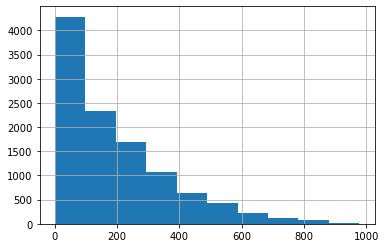

In [33]:
#왜곡 여부 확인
y.hist() # 정규분포 X

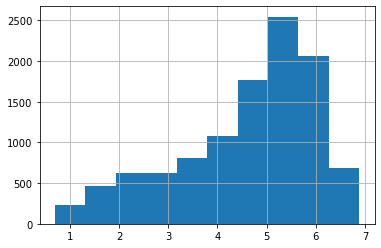

In [37]:
#로그 변환 for 정규분포
y_log = np.log1p(y)
y_log.hist()

#로그 변환에 log 대신 log1p를 사용하는 이유?
# log(x)에서 x가 0이면 값이 무한대가 될 수 있으므로 이를 방지하기 위해 
# log(x+1)을 의미하는 log1p를 이용해 로그변환 할 수 있다.

### 2-3)
로그 변환한 값을 새로운 target값으로 설정하여 2-1)과 동일하게 회귀 예측을 진행해주세요. 마찬가지로, 마지막에는 위에서 정의한 'evaluate_regr' 함수를 이용하여 MSE, RMSE, RMSLE를 모두 계산해주세요. (train_test_split의 사용 시, test_size=0.3, random_state=0)

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.3, random_state=0) 

lr2 = LinearRegression()
lr2.fit(X_train, y_train)
lr2_pred = lr2.predict(X_test)

# 주의! 로그변환된 값을 다시 원래 스케일로 돌려서 해석해야함 
y_test_exp = np.expm1(y_test) # 테스트셋의 target값이 로그변환 됐으므로 다시 변환
lr2_pred_exp = np.expm1(lr2_pred) # 예측갑 역시 로그변환된 target 기반으로 학습됐으므로 다시 변환
evaluate_regr(y_test_exp, lr2_pred_exp)

RMSLE: 1.017, RMSE: 162.594, MAE: 109.286


### 2-4)
성능이 좋아진 지표도 있는 반면 나빠진 지표도 있습니다. 이유를 알기 위해 각 피처의 회귀계수 값을 시각화한 결과는 다음과 같습니다.

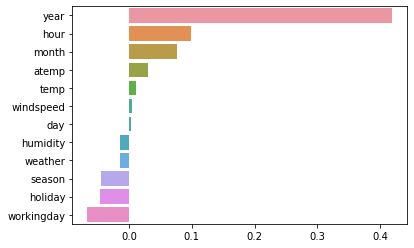

In [44]:
coef = pd.Series(lr2.coef_, index=X.columns)
coef_sort = coef.sort_values(ascending=False)
sns.barplot(x=coef_sort.values, y=coef_sort.index)

시각화 결과를 보니 범주형인 year피처가 2011, 2012라는 큰 숫자형으로 존재하여 회귀 계수 연산에 큰 영향을 주고 있음을 알 수 있습니다. 해당 피처 인코딩에 앞에서 이전에 배웠던 원-핫 인코딩을 적용해주세요.

In [46]:
X_onehot = pd.get_dummies(X, columns=['year'])

### 2-5)
원-핫 인코딩이 적용된 feature를 새로운 feature로 설정하여 2-1과 동일하게 회귀 예측을 진행해주세요.

마지막엔 위에서 정의한 'get_model_predict'을 사용하여 linear 회귀, ridge 회귀, lasso 회귀 각각의 성능 평가 수치를 계산해주세요. (ridge alpha값 = 10, lasso alpha값 = 0.01)

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X_onehot, y_log, test_size=0.3, random_state=0) 

lr = LinearRegression()
ridge = Ridge(alpha=10)
lasso = Lasso(0.01)

for model in [lr, ridge, lasso]:
    get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=True)

### LinearRegression ###
RMSLE: 1.017, RMSE: 162.594, MAE: 109.286
### Ridge ###
RMSLE: 1.017, RMSE: 162.593, MAE: 109.283
### Lasso ###
RMSLE: 1.018, RMSE: 162.751, MAE: 109.365


원-핫 인코딩 적용 후 선형 회귀의 예측 성능이 많이 향상되었습니다. 상위 회귀 계수를 확인해보면 다음과 같습니다. 월, 주말/주중과 같이 상식선에서 이해하기 쉬운 피처의 회귀 계수가 높아졌습니다.

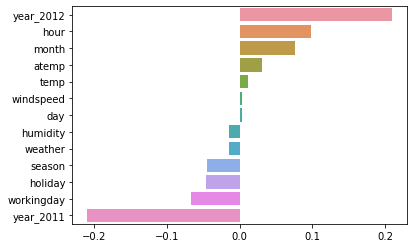

In [50]:
coef = pd.Series(lr.coef_ , index=X_onehot.columns)
coef_sort = coef.sort_values(ascending=False)[:20]
sns.barplot(x=coef_sort.values , y=coef_sort.index)

### 2-6)
마지막으로 회귀 트리를 이용하여 회귀 예측을 수행해 보겠습니다. 로그 변환된 target값과 원-핫 인코딩된 feature는 그대로 이용하고, 랜덤 포레스트, GBM, XGBoost, LightGBM을 순차적으로 성능 평가해주세요.

(DataFrame이 입력되면 오류가 발생하는 모델이 있습니다. DataFrame의 values 속성을 이용해 DataFrame을 넘파이 ndarray로 변환하여 이용하세요.)

In [56]:
rf = RandomForestRegressor(n_estimators=500)
gbm = GradientBoostingRegressor(n_estimators=500)
xgb = XGBRegressor(n_estimators=500)
lgbm = LGBMRegressor(n_estimators=500)

for model in [rf, gbm, xgb, lgbm]:
    get_model_predict(model, X_train.values, X_test.values, y_train.values, y_test.values, is_expm1=True)

### RandomForestRegressor ###
RMSLE: 0.333, RMSE: 48.058, MAE: 29.152
### GradientBoostingRegressor ###
RMSLE: 0.318, RMSE: 47.148, MAE: 28.741
[13:48:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
### XGBRegressor ###
RMSLE: 0.319, RMSE: 47.859, MAE: 29.546
### LGBMRegressor ###
RMSLE: 0.301, RMSE: 43.070, MAE: 26.025


# 이상치, 영향점 실습

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import OLSInfluence
import matplotlib.font_manager as fm

df = pd.read_csv('C:/Users/USER/BITAmin/data/auto-mpg.csv')
df.head(3)

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite


In [3]:
#horsepower 열의 자료형 변경 (문자열 -> 숫자)
df['horsepower'].replace('?', np.nan, inplace = True)
df.dropna(subset = ['horsepower'], axis = 0, inplace = True) #누락 데이터 행 삭제
df['horsepower'] = df['horsepower'].astype('float')

# 반응변수에 log를 취한 이유는 오차항의 이분산성을 개선하기 위함이고,
# 설명변수에 polynomial(2차)항을 더한 이유는 잔차의 독립성과 비선형성을 보장하기 위함입니다. 
model_auto3 = smf.ols('np.log(mpg)~horsepower+np.square(horsepower)', data = df).fit() 

#아래 그림은 각각 polynomial 항을 넣기 전후의 잔차 그래프입니다.

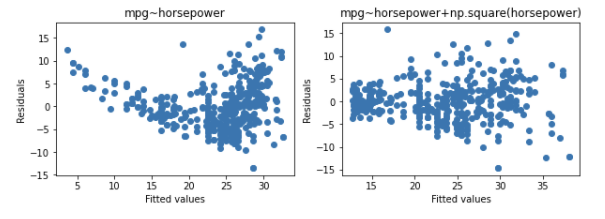

### 3-1)
'mpg' 변수와 'horsepower' 변수의 scatter plot을 그려주세요.

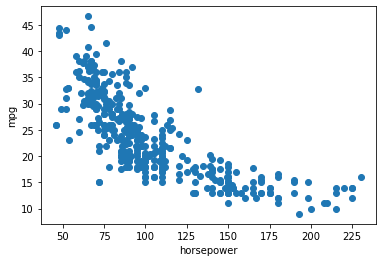

In [7]:
plt.scatter(df['horsepower'], df['mpg']) 
plt.xlabel('horsepower')
plt.ylabel('mpg')
plt.show()

### 3-2)
위에서 만든 모델을 활용하여 studentized residual plot을 그려주세요.

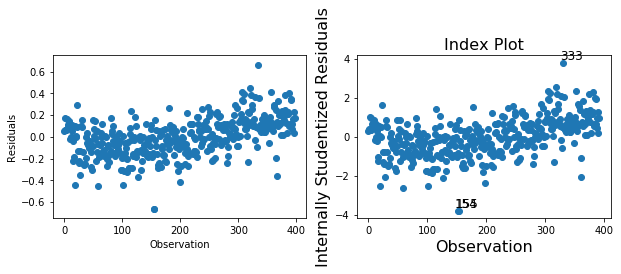

In [9]:
# 이상치 확인: 잔차 그래프 및 스튜던트화 잔차 그래프 시각화
inf = OLSInfluence(model_auto3)
inf.summary_frame()
fig, ax = plt.subplots(1, 2, figsize=(10,3))
ax[0].scatter(df.index, model_auto3.resid)
ax[0].set_xlabel('Observation')
ax[0].set_ylabel('Residuals')
inf.plot_index('resid', threshold=3, ax=ax[1]) 
plt.show()

### 3-3)
영향점 확인을 위해 leverage 통계량을 시각화해주세요.

C:\Users\USER\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


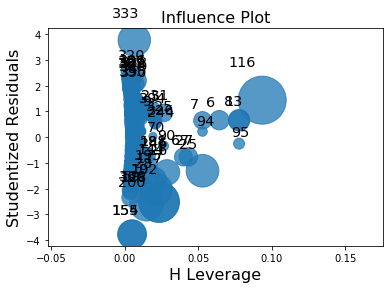

In [10]:
# 영향점 확인: Leverage 통계량 시각화
inf.plot_influence()
plt.show()

### 3-4)
영향점 확인을 위해 Cook's distance를 시각화해주세요.

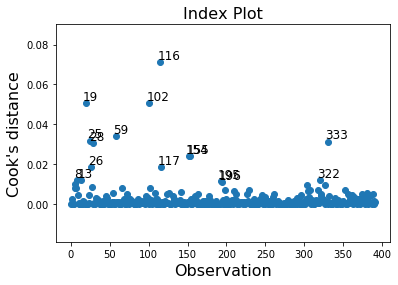

In [12]:
# 영향점: Cook's distance 시각화
inf.plot_index('cook', threshold = 4/(model_auto3.nobs-2-1))
plt.show()

### 3-5)
앞에서 시각화한 것을 바탕으로 이상치와 영향점을 어떻게 처리하면 좋을지 각자의 생각을 자유롭게 적어주세요.
 

* 예시 답안: 시각화 결과 이상치와 영향점이 꽤나 많아보인다. 모두 제거하기엔 데이터 손실이 크므로 여러 통계량을 종합해봤을 때 155, 333, 116번 관측치를 제거하기로 결정했다.


* 이상치/영향점 처리는 분석가의 몫이므로 정답이 없으므로 적절한 근거가 있다면 모두 타당합니다. 예시 답안은 참고만 해주세요!

# 수고하셨습니다!!!!! ^_^